# Data Preparation

The first step of this walkthrough is getting our hands on the data that will train and test our PyTorch model. The data is available from a number of sources, including websites like [kaggle](https://www.kaggle.com/c/digit-recognizer/data) and [Louisiana State University's website](https://csc.lsu.edu/~saikat/n-mnist/). It's even made available directly through [torchvision](https://pytorch.org/vision/0.8/datasets.html#mnist).

We are going to go right to the source on this one, and download it directly from [Yann LeCun's website](http://yann.lecun.com/exdb/mnist/). The dataset has become quite widely used in the world of image classification, and it was popularized after Yann's 1998 Paper [Gradient-based learning applied to document recognition]
(https://ieeexplore.ieee.org/document/726791).


!TODO! Describe dataset
## Data Sources (word?)
There are 4 files we need to train our network:
- The set of training images:  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
- The set of training labels:  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
- The set of testing images:   http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
- The set of testing labels:   http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

To download them, I recommend simply (from the root level of this repository):
```
$> mkdir data
$> wget --directory-prefix data http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
$> wget --directory-prefix data http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
$> wget --directory-prefix data http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
$> wget --directory-prefix data http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
```

The files are gunzipped, so we'll need to uncompress them. We can do so in one line:
```
$> gunzip data/*
```

Now we have all the data we need on our local machine. Let's start out by taking a look at the data and figuring out how to parse it.

## Data Parsing and Loading

*Aside: Many of you may wonder: why go through all the trouble of parsing the dataset when it is so easily available in nicer formats from other sources. (As mentioned before, `torchvision` has this dataset built in and ready to be used with a `TrainLoader`.) There's even a python library called `python-mnist` that can automatically parse these files for you. I chose to include this portion of the walkthrough because I myself found it of great educational value to learn how to parse the data from raw, unsigned bytes. In the real world of machine learning, your source data is going to start off messy. It's not going to be already built in to your ML framework where you can download it and create a fancy training iterator with a single function call. I believe that learning to parse the data yourself is good practice for when it comes time to use machine learning in your own projects, on your own data, and in pursuit of your interests.*

The data is stored as bytes. A schema is provided on the website for the byte ordering:
- Labels file:
    - **Bytes \[0,4):** Magic Number (MSB)
    - **Bytes \[4,8):** 32 bit signed integer representing the number of labels
    - **Bytes \[8,):**  The image labels. Each unsigned byte is a label.

- Images file:
    - **Bytes \[0,4):** Magic Number (MSB)
    - **Bytes \[4,8):** 32 bit signed integer representing the number of images
    - **Bytes \[8,12):** 32 bit signed integer representing the number of rows per image
    - **Bytes \[12,16):** 32 bit signed integer represneting the number of columns per image
    - **Bytes \[15,):** The pixels. Each is an unsigned byte with a value between 0 and 255.

#### We can start by parsing the labels file. It has a slighly simpler schema than the images file, so it will get us used to reading files as raw bytes.

In [13]:
# Read in the labels file
labels = []
with open("./data/train-labels-idx1-ubyte", 'rb') as label_file:
    label_file.seek(4)  # Skip past the magic number
    num_labels = int.from_bytes(label_file.read(4), 'big')  # Read and parse uint32 that holds the number of labels
    
    # Iterate through the remainder of the file
    for _ in range(num_labels):
        labels.append(int.from_bytes(label_file.read(1), 'big'))  # Read a byte, parse an integer from it, and store it.
    
    # Check that we've reached the end of the file
    assert label_file.tell() == label_file.seek(0,2)

We should run a few checks to make sure that we parsed everything correctly. Here's what we can check
- The number of labels we parsed is equal to the number stored in bytes \[4,7) of the file
- Every label should be in the [0,9]

In [16]:
assert len(labels) == num_labels
assert any(label not in range(0,10) for label in labels) == False

#### Alright. We've got the labels. Time to move on to the images.

This file is going to be a little harder to parse, but all we have to do is think about what data makes up an "image". An image is a made up of pixels, and those pixels are arranged in 2d space with a given height and a given width. In the case of grayscale images, like the ones we're using, the value of those pixels is represented by a single number. Thinking about this for a little bit, we can come up with psuedo-code showing how we would read a single image of known dimensions:

```
image_file = read(image_file)
image_data = list(list())  # 2d list
for r in [0,number_of_rows):
    for c in [0,numer_of_cols):
        pixel = image_fule.readbyte()
        image_data[r][c] = pixel
```

In order to read multiple images, all we have to do is add one more for loop.

Let's read in the images. Because python, the actual code doesn't look too much different from the psudeo code.

| !TODO! Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black).



In [52]:
with open("./data/train-images-idx3-ubyte", 'rb') as image_file:
    image_file.seek(4)  # Skip past magic number
    num_images = int.from_bytes(image_file.read(4), "big")  # uint32 telling us the number of images
    num_rows = int.from_bytes(image_file.read(4), "big")    # uint32 telling us the number of rows per image
    num_cols = int.from_bytes(image_file.read(4), "big")    # uint32 telling us the number of columns per image
    images = []
    
    # Iterate through the pixels and group them accordingly.
    for _ in range(num_images):
        image = []
        for _ in range(num_rows):
            col = list(image_file.read(num_cols))
            image.append(col)          
        images.append(image)

# Note that np.reshape(np.array(list(images_file.read(num_rows * num_columns))), (num_images, num_rows, num_columns) is an easy one liner

Again, we can run a few checks to make sure that we parsed everything correctly:

In [28]:
assert len(images) == num_images
assert len(images[0]) == num_rows
assert len(images[0][0]) == num_cols

#### Finally, we can print out a few of our images and their associated labels to make sure we got everything right

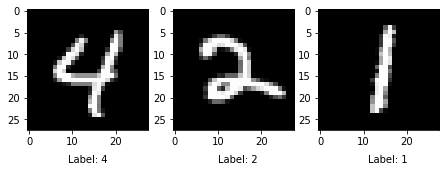

In [49]:
import numpy as np
import matplotlib.pyplot as plt

i1, i2, i3 = np.random.randint(0, num_images, 3)   # Three randomly chosen images
l1, l2, l3 = labels[i1], labels[i2], labels[i3]    # Get the associated labels for the chosen images
fig = plt.figure(figsize=(10,10))

fig.add_subplot(1,4,1)
plt.imshow(images[i1], cmap='gray')
plt.text(9, 35, f"Label: {l1}")

fig.add_subplot(1,4,2)
plt.imshow(images[i2], cmap='gray')
plt.text(10,35, f"Label: {l2}")

fig.add_subplot(1,4,3)
plt.imshow(images[i3], cmap='gray')
plt.text(11,35, f"Label: {l3}")

plt.show()

And there we have it, we've successfully parsed our training data!